# Trotter Extrapolation

## James D. Watson, Jacob Watkins
## August 2023

### TODO:

- Generalize Trotter code to any order formula (currently first order), or at least 2nd order
- Calculate observable (Magnetization? Something local to one qubit?)

## Theory

From Equation (1) of [this text](https://arxiv.org/abs/1711.10980), we want to simulate the 1D Heisenberg model.

$$
H = \sum_{i=1}^n \sigma_i \cdot \sigma_{i+1} + h_j \sigma_j^z
$$

with $h_j \in [-h,h]$ randomly and uniformly sampled. Suppose we wish to simulate $e^{-i H T}$ on a quantum computer using product formulas. A natural choice is to split according to even-odd staggering of the interaction term, and then do the $Z$ rotations in their own grouping. If $n$ is odd, there will be one term left over. I don't think we should fret, probably just choose even $n$ for simplicity since we are only exploring our method. 

In [2]:
# Imports

import numpy as np
import scipy.linalg as sla
import numpy.linalg as nla
import matplotlib.pyplot as plt

## Useful Pauli and qubit manipulations

In [3]:
# Computes Kronecker (tensor) product of a list of matrices
# Example:
# Input: [X,Y,Z,Y]
# Return: X \ox Y \ox Z \ox Y
def kron_list(matrix_list):
    result = matrix_list[0]
    for i in range(1,len(matrix_list)):
        result = np.kron(result,matrix_list[i])
        
    return result

# Pauli matrices
I = np.array([[1.,0],[0,1.]], dtype='complex')
X = np.array([[0,1.],[1.,0]], dtype='complex')
Y = np.array([[0,-1.j],[1.j,0]], dtype='complex')
Z = np.array([[1.,0],[0,-1.]], dtype='complex')

# Converts string representation of paulis to list of matrices,
# Example:
# Input: "XYZY"
# Return: [X,Y,Z,Y]
def paulistring_to_list(paulistring): 
    matrix_list = list(paulistring)
    translate = {'I':I, 'X':X, 'Y':Y, 'Z':Z}
    for p in range(len(paulistring)):
        matrix_list[p] = translate[matrix_list[p]]
    return matrix_list

# Computes generalized pauli matrix, given a string in standard form,
# Example:
# Input: "XYZY"
# Return: X \ox Y \ox Z \ox Y
def pauli_matrix(paulistring):
    return kron_list(paulistring_to_list(paulistring))

# Computes generalized pauli matrix, specified by non-identity pieces. Nonidentities encoded as dictionary
# of the form {k:'P', ..., } where k is the integer location and P is a pauli
# Example:
# Input: {0: 'X', 3:'Z', 5:'X'}, 6
# Return: X\ox I \ox  Z \ox I \ox I \ox X
def sparse_pauli(nonidentities, nqubits):
    #starting string is all identity
    paulilist = []
    for i in range(0, nqubits):
        paulilist.append('I')
    
    #Change string to paulis specified by dictionary
    for key in nonidentities:
        paulilist[key] = nonidentities[key]
    paulistring = ''.join(paulilist)
    
    return pauli_matrix(paulistring) 

# Returns the matrix of \sigma . \sigma between sites i and j
# Example:
# Input: 0,1,4
# Return: X\ox X \ox I \ox I + Y\ox Y \ox I \ox I + Z\ox Z \ox I \ox I
def sigma_dot_sigma(i,j,nqubits):
    return sparse_pauli({i:'X',j:'X'},nqubits) + sparse_pauli({i:'Y',j:'Y'},nqubits) + sparse_pauli({i:'Z',j:'Z'},nqubits)

# Qubit computational basis
zero = np.array([1.,0], dtype ='complex')
one = np.array([0,1.], dtype ='complex')

# Convert bitstring to list of single-qubit kets
# Example: 
# Input: "0101"
# Output: list( (1,0), (0,1), (1,0), (0,1) )
def bitstring_to_list(bitstring):
    bitlist = list(bitstring)
    translate = {'0':zero, '1':one}
    for b in range(len(bitstring)):
        bitlist[b] = translate[bitlist[b]]
    return bitlist

# Convert bitstring to full vector/array describing each qubit.
# Example: 
# Input: "0101"
# Output:  (1,0) \ox (0,1) \ox (1,0) \ox (0,1) 
def basis_ket(bitstring):
    return kron_list(bitstring_to_list(bitstring))


# Outputs a bit string with certain positions set to 1, and otherwise set to zero:
# Example: 
# Input: [0,1,2],3
# Output:  (0,0,0,0,0,0,0,0,1)
def sparse_bitstring(ones, nqubits):
    bitlist = []
    for i in range(0,nqubits):
        bitlist.append('0')
    
    #Flip certain bits to one, as specified by dictionary
    for qubit in ones:
        bitlist[qubit] = '1'
    bitstring = ''.join(bitlist)
    
    return basis_ket(bitstring)

## Chebyshev functions

`np.polynomial.chebyshev` is a class for chebyshev polynomials. Looks new and somewhat untested.

In [4]:
def cheb_nodes(n, width = 1, center = 0):
    nodes = np.zeros(n)
    for j in range(n):
        nodes[n-j-1] = center + (width/2)* np.cos((2*j+1)*np.pi/(2*n))
    return nodes

## Simulation functions

In [5]:
# Generates the 1D Heisenberg chain Hamiltonian specified in the introduction.
def heisenbergH(nqubits, hlist):
    H = sigma_dot_sigma(0,1,nqubits) + hlist[0]*sparse_pauli({0:'Z'}, nqubits)
    for j in range(1, nqubits):
        H += sigma_dot_sigma(j, (j+1)%nqubits, nqubits) + hlist[j]*sparse_pauli({j:'Z'}, nqubits)
    return H

# Generates the exact time evolution.
def Uexact(H, T):
    return sla.expm(-1.j*H*T)

# TODO: generalize for higher order formulas (or at least 2).
# First term in Hlist is applied to state first
def Utrot_short(Hlist, t, order = 1):
    m = len(Hlist) # number of terms
    result = sla.expm(-1.j*Hlist[0]*t)
    for k in range(1,m):
        result = sla.expm(-1.j*Hlist[k]*t) @ result
    
    return result
    
# Code only works for first order
def Utrot_long(Hlist, T, steps, order = 1):
    single_step = Utrot_short(Hlist, T/steps, order)
    
    integer_steps = int( np.floor(steps) )
    fractional_step = steps - integer_steps
    
    integer_step_evolve = nla.matrix_power(single_step, integer_steps)
    fractional_step_evolve = sla.fractional_matrix_power(single_step, fractional_step)
    
    total_evolution = integer_step_evolve @ fractional_step_evolve 
    
    return total_evolution

# Computes the 1-norm characterising the Hamiltonian & number of steps needed.
def Heisenberg_one_norm(nqubits, hlist):
    
    # First compute norm associated with the 2 qubit \sigma.\sigma terms.
    norm = (nqubits-1)*3
    
    # Compute part of norm associated with single-qubit terms.
    k = 0
    for k in range(nqubits):
        norm += np.abs( hlist[k] )
        
    return norm

# Generate Breakdown of the Heisenberg Hamiltonian

In [6]:
## Define the even, odd and potential terms for an arbitrary nunber of qubits and a given hlist.

def Even_Heisenberg_Terms(nqubits):
    Even = sigma_dot_sigma(0, 1, nqubits)
    for j in range(2,nqubits,2):
        Even += sigma_dot_sigma(j, (j+1)%nqubits, nqubits)
        
    return Even

def Odd_Heisenberg_Terms(nqubits):
    
    Odd = sigma_dot_sigma(1, 2%nqubits, nqubits)
    for j in range(3,nqubits,2):
        Odd += sigma_dot_sigma(j, (j+1)%nqubits, nqubits)
        
        
    return Odd

def Potential_Heisenberg_Terms(nqubits, hlist):
    
    Potential = np.sum([hlist[j]*sparse_pauli({j:'Z'}, nqubits) for j in range(nqubits)], axis = 0)
        
    return Potential




# Local Observable and Expectation Value Functions

In [7]:
## Define a Local Observable:

## Computes  Hermitian observable, specified by Pauli strings. Input is a list of dictionaries: nonidentities encoded as dictionary
## of the form {k:'P', ..., } where k is the integer location and P is a pauli. Pauli strings are then input as list.
# Example:
# Input: [{0: 'X', 3:'Z', 5:'X'}, {1: 'X'}], 6
# Return: X\ox I \ox  Z \ox I \ox I \ox X + I\ox X \ox  I \ox I \ox I \ox I
def observable(List_Pauli_strings, nqubits):

    local_observable = 0
    for k in range(len(List_Pauli_strings)):
        local_observable +=  sparse_pauli( List_Pauli_strings[k], nqubits )
    
    return local_observable

## Take expectation value of 'observable' with respect to to 'state'
# Example:
# Input: sparse_bitstring([0], 1), observable([{0: 'Z'}], 1) 
# Output: -1
def expectation_value(state, observable):
    
    normalisation =   np.vdot(state, state )  
    # Throw an exception if the state is not normalised.
    if (normalisation -1) > 0.00001:
        raise ValueError("State is not normalised")
    
    # Calculate the expectation of the state. Use vdot to get complex conjugate.
    expectation = np.vdot(state, observable.dot(state) )
    
    # Throw an exception if there is a significant imaginary part to the expectation value.
    if np.abs(expectation.imag) > 0.00001:
        raise ValueError("Expectation value should be entirely real")
        
    # Return only the real part of the expectation value (imaginary part should be zero).
    return np.real(expectation)

## Finds the expectation value with respect to the Trotterized time evolution. Define the function in terms of x = 1/steps.
# Example: 
# Input: [Even, Odd, Potential], sparse_bitstring([0,1], 2), 10, 0.01, observable([{0: 'Z'}], 2) 
# Output: -1 + 0.j
def Trotterized_Expectation(Hlist, initial_state, time, x, observable, order = 1):
    
    steps = 1/x
    
    # Calculate the Trotterized time-evolution operator and apply to the initial state.
    Trotterized_evolution_operator = Utrot_long(Hlist, time, steps, order )
    time_evolved_state = initial_state  @ Trotterized_evolution_operator
    
    return expectation_value(time_evolved_state, observable)
    
## Computes the time-evolved expectation value from the *exact* evolution.  
# Example: 
# Input: heisenbergH(nqubits, hlist), sparse_bitstring([0,1], 2), 10, observable([{0: 'Z'}], 2) 
# Output: -1 + 0.j
def Exact_Expectation(Hamiltonian, initial_state, time, observable):
    
    # Calculate the exact evolution operator.
    evolution_operator = Uexact(Hamiltonian, time)
    # Apply the exact evolution to the initial state.
    time_evolved_state = initial_state  @ evolution_operator
    
    return expectation_value(time_evolved_state, observable)

## Compares the difference between the exact and Trotterized expecation values.
def difference_function(Hlist, initial_state, time, x, observable, nqubits, order = 1 ):
    
    # Calculate full Heisenberg Hamiltonian. hlist = Hlist[2]
    Hamiltonian = heisenbergH(nqubits, Hlist[2])
    #Hamiltonian = np.sum(Hlist,axis=0)
    
    # Calculate the difference between the exact evolution and the Trotter-zed evolution.
    diff = Exact_Expectation(Hamiltonian, initial_state, time, observable) - Trotterized_Expectation(Hlist, initial_state, time, x, observable, order = 1)
    
    return diff

## Calculates the minimum number of steps required analyticity to be maintained (using the one-norm bound).
def min_step_number(nqubits, hlist, time):
    
    one_norm = Heisenberg_one_norm(nqubits, hlist)
    min_step_no = np.ceil(one_norm*time)
    
    return float(min_step_no)


In [58]:
## Plot the difference function for different step values.
nqubits = 6
h = 1
#time = 100000000

T1 = 10**8
T2 = 10**(2)
T3 = 10**(-2)


# Define the Hamiltonian and the groupings of its terms.
hlist = (np.random.rand(nqubits)*2 -1)*h
Hlist = [Even_Heisenberg_Terms(nqubits), Odd_Heisenberg_Terms(nqubits), Potential_Heisenberg_Terms(nqubits, hlist)]
time = 1/Heisenberg_one_norm(nqubits, hlist)

if sla.norm(heisenbergH(nqubits, hlist) - np.sum(Hlist,axis=0),2) > 0.0000001:
    raise ValueError("Trotterised Hamiltonian is not equal to actual Hamiltonian")


local_obs = observable([{0: 'Z'},{nqubits-1: 'Z'}, {1: 'X'} ], nqubits)
temp_list =[0]*nqubits
temp_list[nqubits//2] = 1
#temp_list[0] = 1
#temp_list[1] = 1
state = sparse_bitstring(temp_list, nqubits)

#max_s_value = 1/min_step_number(nqubits, hlist, time)
max_s_value = 1
s_step_size = max_s_value/1000

s_value_array = np.arange(s_step_size, max_s_value, s_step_size)
output_list_1 = [difference_function(Hlist, state, T1, s, local_obs, nqubits, order = 1 ) for s in s_value_array]
output_list_2 = [difference_function(Hlist, state, T2, s, local_obs, nqubits, order = 1 ) for s in s_value_array]
output_list_3 = [difference_function(Hlist, state, T3, s, local_obs, nqubits, order = 1 ) for s in s_value_array]

difference_list = np.array(output_list_1) - np.array(output_list_2)



[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02  0.021 0.022 0.023 0.024
 0.025 0.026 0.027 0.028 0.029 0.03  0.031 0.032 0.033 0.034 0.035 0.036
 0.037 0.038 0.039 0.04  0.041 0.042 0.043 0.044 0.045 0.046 0.047 0.048
 0.049 0.05  0.051 0.052 0.053 0.054 0.055 0.056 0.057 0.058 0.059 0.06
 0.061 0.062 0.063 0.064 0.065 0.066 0.067 0.068 0.069 0.07  0.071 0.072
 0.073 0.074 0.075 0.076 0.077 0.078 0.079 0.08  0.081 0.082 0.083 0.084
 0.085 0.086 0.087 0.088 0.089 0.09  0.091 0.092 0.093 0.094 0.095 0.096
 0.097 0.098 0.099 0.1   0.101 0.102 0.103 0.104 0.105 0.106 0.107 0.108
 0.109 0.11  0.111 0.112 0.113 0.114 0.115 0.116 0.117 0.118 0.119 0.12
 0.121 0.122 0.123 0.124 0.125 0.126 0.127 0.128 0.129 0.13  0.131 0.132
 0.133 0.134 0.135 0.136 0.137 0.138 0.139 0.14  0.141 0.142 0.143 0.144
 0.145 0.146 0.147 0.148 0.149 0.15  0.151 0.152 0.153 0.154 0.155 0.156
 0.157 0.158 0.159 0.16  0.161 0.162 0.163 0.164 0.16

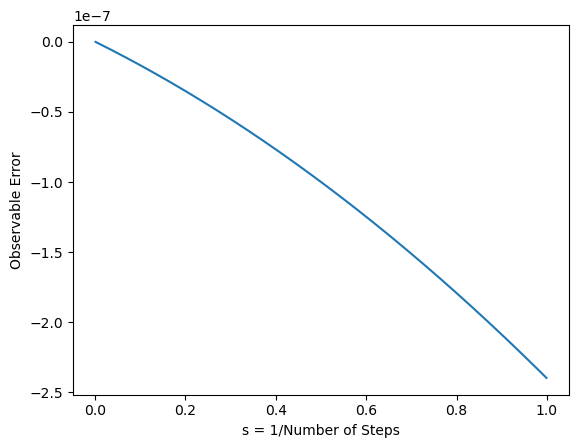

In [61]:
plt.plot(s_value_array, output_list_3)
plt.xlabel('s = 1/Number of Steps')
plt.ylabel('Observable Error')
print(s_value_array)

In [54]:
print(difference_list)

[ 9.17920948e-01  9.15377510e-01  8.46949462e-01  8.98698863e-01
  8.74086584e-01  8.75809659e-01  3.36626807e-01  9.07119332e-01
  4.92790246e-01 -4.85978493e-02  4.96308785e-01  7.10012633e-01
  5.62940152e-01 -1.88882194e-02  2.84192133e-01 -9.84133662e-02
  6.62127074e-01 -3.41260997e-02  2.86135387e-01  8.00592314e-01
  6.24751775e-01  1.73895778e-01  2.10392301e-01  4.85070206e-01
  1.32454384e-01  5.51087855e-01 -4.22288847e-01  9.92734481e-02
  4.47191630e-01  6.03355118e-01  4.14971340e-01  6.54853512e-01
  6.00301007e-01  2.15276265e-02  4.01789393e-01  9.45223863e-01
 -3.96945014e-01  7.94936061e-01  7.09117860e-01  7.75598303e-01
  9.30129454e-01  8.71874139e-01  9.20876786e-01  9.18257850e-01
  9.17997314e-01  9.21159390e-01  9.15869917e-01  6.43929834e-01
 -3.08825917e-01  5.19517485e-01  3.16552264e-01  3.10311021e-02
  3.81471117e-01  5.95585636e-01  9.87509573e-01  3.54911009e-01
  1.25536606e-01  3.01535348e-01  5.59786716e-01  3.14839480e-01
  5.08710008e-01 -3.97772

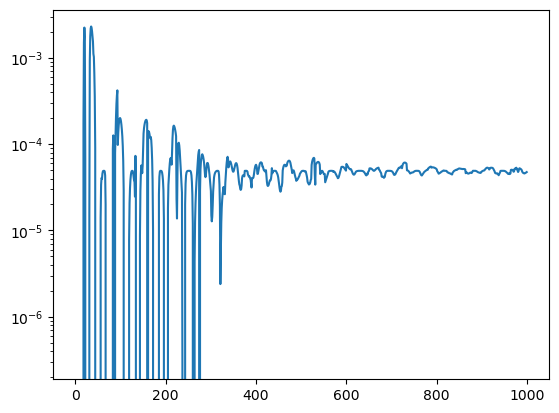

In [22]:

plt.semilogy(s_value_array, output_list)

In [ ]:
# Parameters
nqubits = 4
h = 0
steps = 1000
T = 8

# Generate a list of random coefficients.
hlist = (np.random.rand(nqubits)*2 -1)*h

# Trotter pieces: group the odd and even Hamiltonian terms.

Even = sigma_dot_sigma(0, 1, nqubits)
for j in range(2,nqubits,2):
    Even += sigma_dot_sigma(j, (j+1)%nqubits, nqubits)

Odd = sigma_dot_sigma(1, 2%nqubits, nqubits)
for j in range(3,nqubits,2):
    Odd += sigma_dot_sigma(j, (j+1)%nqubits, nqubits)
    
Potential = np.sum([hlist[j]*sparse_pauli({j:'Z'}, nqubits) for j in range(nqubits)], axis = 0)

Hlist = [Even, Odd, Potential]

Even_terms = Even
Odd_terms = Odd


A = Uexact(heisenbergH(nqubits, hlist), T)
B = Utrot_long(Hlist, T, steps)

# Checking

Text(0, 0.5, 'Observable Error')

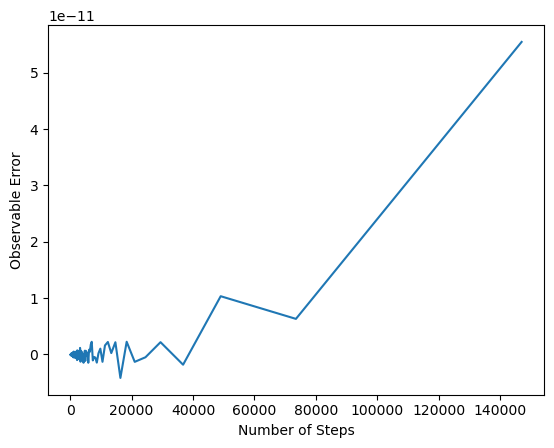

In [10]:
## Checking time evolution on n-qubits does decrease as the step number increases.
# Define initial parameters.
time = 10
local_obs = observable([{0: 'Z'},{nqubits-1: 'X'}, {1: 'X'} ], nqubits)
state = sparse_bitstring(list(np.arange(nqubits)), nqubits)

# Exact Evolution
Hamiltonian = heisenbergH(nqubits, hlist)
C_mat =  Uexact(Hamiltonian, time)

# Inexact Evolution
steps = min_step_number(nqubits, hlist, time)
D_mat = Utrot_long(Hlist, time, steps )


min_no_steps = min_step_number(nqubits, hlist, time)
max_s_value = 1/min_step_number(nqubits, hlist, time)

s_step_size = max_s_value/1000


s_value_array = np.arange(s_step_size, max_s_value, s_step_size)
step_value_array = [1/s for s in s_value_array]
D_array = [ Utrot_long(Hlist, time, step ) for step in step_value_array]

# Difference in norms of evolution operators
norm_diff_array = [sla.norm(C_mat-D,2) for D in D_array]

# Now calculate the difference between the exact and Trotterized expectation values.
exact_expectation = Exact_Expectation(Hamiltonian, state, time, local_obs)
observable_diff_array = [ exact_expectation - Trotterized_Expectation(Hlist, state, time, 1/x, local_obs, order = 1) for x in step_value_array]

# Plot the norm of the difference between the norms of exact and Trotterised evolution
#plt.plot(step_value_array, norm_diff_array )

# Plot the difference between the local observables of exact vs Trotterised.
plt.plot(step_value_array, observable_diff_array )
plt.xlabel('Number of Steps')
plt.ylabel('Observable Error')


In [203]:
# Unitaries don't line up. Hamiltonians seem to match.
sla.norm(A-B,2)

0.015775987754208232

In [280]:
# Hamiltonians line  up
sla.norm(heisenbergH(nqubits, hlist) - np.sum(Hlist,axis=0),2)

2.220446049250313e-16

In [299]:
Trotterized_Expectation(Hlist, state, 100, max_s_value, local_obs, order = 1)

-1.9999999999998852

In [81]:
for j in range(0,6,2):
    print(j)

0
2
4


In [8]:
paulistring_to_list("XYZ")

[array([[0.+0.j, 1.+0.j],
        [1.+0.j, 0.+0.j]]),
 array([[ 0.+0.j, -0.-1.j],
        [ 0.+1.j,  0.+0.j]]),
 array([[ 1.+0.j,  0.+0.j],
        [ 0.+0.j, -1.+0.j]])]

In [35]:
List_Pauli =[{0: X, 3:Z, 5:X}, {1: X}]
print( type(List_Pauli[0]))

<class 'dict'>


In [43]:
sla.norm(observable([{0: 'X', 3:'Z', 5:'X'}, {1: 'X'}], 6) - sparse_pauli( {0: 'X', 3:'Z', 5:'X'}, 6 ) - sparse_pauli( {1: 'X'}, 6 ),2)

#sparse_pauli( {0: 'X', 3:'Z', 5:'X'}, 6 )

0.0

In [96]:
local_obs = observable([{0: 'Z'},{1: 'X'} ], 2)
state = sparse_bitstring([0,1], 2)
print(local_obs)
print(state)
print(expectation_value(state, local_obs))

[[ 1.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 1.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  1.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j -1.+0.j]]
[0.+0.j 0.+0.j 0.+0.j 1.+0.j]
(-1+0j)


In [117]:
Trotterized_Expectation(Hlist, state, 10, 0.0001, local_obs, order = 1)

(-1.0000000000012996+0j)

In [116]:
Exact_Expectation(heisenbergH(2, hlist), state, 10, local_obs)

(-1.0000000000000009+0j)

In [130]:
difference_function(Hlist, state, 100, 0.1, local_obs, 2, order = 1 )

(3.164135620181696e-14+0j)

In [235]:
# Hamiltonians line  up
Potential = np.sum([hlist[j]*sparse_pauli({j:'Z'}, nqubits) for j in range(nqubits)], axis = 0)
sla.norm( Potential - (Hlist[2]),2)

0.0